## Exploratory Data Analysis for SECASC HydroViz project

[This project](https://secasc.ncsu.edu/2023/08/28/modeling-hydrologic-simulations-for-past-future-conditions-across-the-conterminous-us/) uses historical and potential future streamflow data that was modeled using the Precipitation-Runoff Modeling System (PRMS) application of the USGS National Hydrologic Model infrastructure (NHM; [Regan and others, 2018](https://pubs.usgs.gov/publication/tm6B9)). 

This notebook takes a look at the hydrologic futures data found [here](https://www.usgs.gov/data/model-input-and-output-hydrologic-simulations-conterminous-united-states-historical-and-future). Data is split up into 4 groups:
- model inputs
- model outputs (for both static and dynamic land cover)
- [streamflow statistics](https://www.sciencebase.gov/catalog/item/get/638763a9d34ed907bf78432b?files.sort=name&files.order=asc&files.metadataFirst=false#attached-files-section) computed on model outputs (for both static and dynamic land cover)
- [geospatial data](https://www.sciencebase.gov/catalog/item/6373c4bdd34ed907bf6c6e4d) representing stream segments and hydrologic units (watersheds)

We will ignore model inputs and outputs in this EDA, assuming that we will not be displaying these raw data. Instead we will focus on the streamflow statistics and geospatial data.


### Setup
Import packages and define the data location.

In [3]:
from pathlib import Path
import geopandas as gpd
import dask.dataframe as dd

data_dir = Path("/import/beegfs/CMIP6/jdpaul3/hydroviz_data")

### Hydrological Statistics

#### Data Structure
The model outputs are a collection of large CSV files (some up to 700MB), but are no where near as large as the raw model outputs.

The statistics files are divided into 52 hydrologic metrics for different time periods (1952-2005, 1976-2005, 2016-2045, 2046-2075, and 2071-2100) and "diff" statistics, which are the precomputed percent difference in the hydrologic metrics between the historical periods (1952-2005 and 1976-2005) and the future periods (2016-2045, 2046-2075, and 2071-2100).

Strangely, the mid century years (2046-2075) overlap the late century years (2071-2100). We should probably figure out why this is the case, because this kind of overlap might look weird in certain data visualizations.

There are a dozen "key" metrics listed in [this document](https://drive.google.com/drive/folders/1h_UVxk1-yUNmA4-bTxiT9Dai4cN0ER2n), with only 5 specifically marked for initial design and testing.

The statistics were computed for both the individual stream segments (polylines), and for hydrologic units (HRUs) which are basically watershed polygons. This means that the statistics can potentially be displayed for both polygon and streamline geometries. It is unclear whether there is a 1:1 relationship between streamlines and their surrounding watersheds.

Let's start by listing all of the CSV files that we unzipped in `download.ipynb`, and removing the metadata files. Check out the first 10 to see the filename structure.

In [25]:
stat_csvs = list(data_dir.joinpath('stats').glob('*.csv'))
for c in stat_csvs:
    if c.name.startswith('streamflow'):
        stat_csvs.remove(c)
stat_csvs = sorted(stat_csvs)

stat_csvs[0:25]

[PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_IPSL-CM5A-LR_historical_r1i1p1_hru_1952_2005.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_IPSL-CM5A-LR_historical_r1i1p1_hru_1976_2005.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_IPSL-CM5A-LR_historical_r1i1p1_seg_1952_2005.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_IPSL-CM5A-LR_historical_r1i1p1_seg_1976_2005.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_IPSL-CM5A-LR_rcp26_r1i1p1_hru_2016_2045.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_IPSL-CM5A-LR_rcp26_r1i1p1_hru_2016_2045_1976_2005_diff.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_IPSL-CM5A-LR_rcp26_r1i1p1_hru_2046_2075.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_IPSL-CM5A-LR_rcp26_r1i1p1_hru_2046_2075_1976_2005_diff.csv'),
 PosixPath('/import/be

We can see the structure is `{land cover type}_{model}_{scenario}_{variant}_{geometry}_{start year}_{end year}` with an option suffix indicating if the values are a pre-calculated difference, and the years that are the baseline for that calculation.

Let's open some files to check the structure and length.

In [26]:
historical_hru, historical_seg, projected_hru, projected_seg = dd.read_csv(stat_csvs[0]), dd.read_csv(stat_csvs[2]), dd.read_csv(stat_csvs[4]), dd.read_csv(stat_csvs[10]),

In [29]:
for csv in [historical_hru, projected_hru, historical_seg, projected_seg]:
    print("CSV length: ", len(csv))
    print(csv.head())


CSV length:  109951
   hru_id     ma3     ma4     ma12      ma13     ma14     ma15     ma16  \
0       1  205.24  147.09   47.770   12.6920   31.160   398.97  349.220   
1       2  176.63  128.26   29.195   24.6130   56.953   117.70   30.786   
2       3  138.98  112.52   63.749   53.0230  107.350   310.29  137.480   
3       4  168.11  124.40  234.650  167.8500  385.670  1569.30  709.170   
4       5  213.41  158.48   16.921    8.2541   17.140   120.28   45.256   

      ma17      ma18  ...  spr_dur7  spr_freq  spr_ord   sum_mag  sum_dur3  \
0  108.340   97.3130  ...   1848.20       9.0    115.5  0.030314  2.621700   
1   16.450   14.9160  ...    425.36       9.5    103.5  0.003161  0.073137   
2   72.395   53.2060  ...    864.66       8.0    106.0  0.024840  1.511300   
3  333.450  288.8600  ...   4269.10       9.0    108.5  0.004045  1.293700   
4   11.625    9.8996  ...    449.37       8.5    108.0  0.003629  0.086977   

   sum_dur7  sum_freq  sum_ord   sum_cv   lf1  
0   6.39810 

Looks like there are 109951 watersheds, and 56540 stream segments. Not a 1:1 relationship! But they all seem to have 53 columns: 1 for the ID, and 52 metrics, which is what we would expect given the information in the metadata.

## Geospatial data

The dataset has shapefiles with lines representing stream segments, and polygons representing watersheds (HRUs). There are also crosswalk files that relate the stream and watershed IDs of the model output to the IDs used in the official USGS National Hydrologic Model infrastructure (NHM).

In [89]:
segment_shps = list(subdirs[1].glob('*.shp'))
segment_shps

[PosixPath('Segments_subset/Segments_subset.shp')]

In [90]:
segments = gpd.read_file(segment_shps[0])
segments

,region,seg_id_nat,geometry
0,01,1,"LINESTRING (2101948.624 2876678.641, 2101941.3..."
1,01,2,"LINESTRING (2167789.031 2829021.852, 2167729.9..."
2,01,3,"LINESTRING (2131936.492 2865675.020, 2131955.7..."
3,01,4,"LINESTRING (2151719.943 2849594.051, 2151812.0..."
4,01,5,"LINESTRING (2155981.103 2842240.715, 2155894.2..."
...,...,...,...
56455,18,56456,"LINESTRING (-1943922.030 1664269.470, -1943834..."
56456,18,56457,"LINESTRING (-1939576.427 1684173.491, -1939582..."
56457,18,56458,"LINESTRING (-1941082.934 1778819.137, -1941078..."
56458,18,56459,"LINESTRING (-2283644.191 2427521.123, -2283652..."


Great, the number of stream segments matches up with the number of rows in the stats data. Let's plot it.

<Axes: >

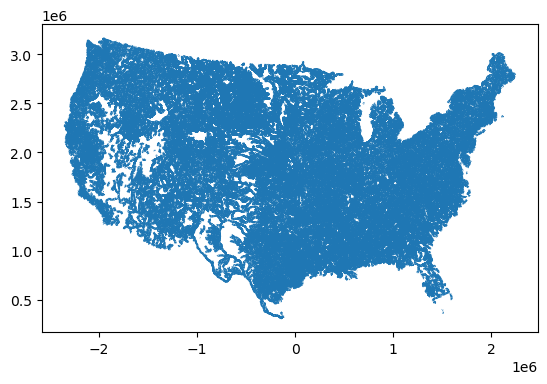

In [83]:
segments.plot()

Now let's try the watersheds.

In [93]:
hru_shps = list(subdirs[3].glob('*.shp'))
hru_shps

[PosixPath('HRU Subset/HRU_subset.shp')]

In [94]:
hru = gpd.read_file(hru_shps[0])
hru

,region,hru_id_nat,geometry
0,17,93013,"POLYGON ((-1661303.115 2221244.978, -1661298.6..."
1,17,93014,"MULTIPOLYGON (((-1532954.896 2215904.774, -153..."
2,17,93015,"POLYGON ((-1532985.250 2215875.115, -1532984.8..."
3,17,93016,"POLYGON ((-1546064.860 2230034.835, -1546065.0..."
4,17,93017,"POLYGON ((-1546065.114 2230081.069, -1546065.0..."
...,...,...,...
109946,18,109947,"POLYGON ((-2258324.780 2396774.791, -2258325.1..."
109947,18,109948,"MULTIPOLYGON (((-2049524.773 2421374.883, -204..."
109948,18,109949,"POLYGON ((-2038034.866 2408355.185, -2038035.2..."
109949,18,109950,"POLYGON ((-2044215.130 2476328.029, -2044279.4..."


<Axes: >

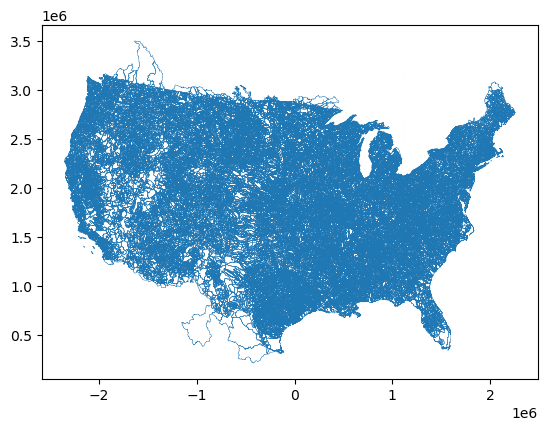

In [96]:
hru.boundary.plot(linewidth=0.25)

OK this looks good, we definitely have the CONUS extent here, plus some watersheds that extend across the border. The number of polygons matches the number of rows in the stats data. This is the base geometry that we will be using to visualize the modeled values.